In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df_full = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df_full.reviews_per_month = df_full.reviews_per_month.fillna(0)

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [4]:
features = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [5]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [7]:
# dt = DecisionTreeClassifier(max_depth=1)
# dt.fit(X_train, y_train)
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
rf = RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
y_pred = rf.predict(X_val)

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [14]:
rmse

0.4603786432595826

In [15]:
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    auc = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%s -> %.3f' % (i, auc))
    aucs.append((i,auc))

10 -> 0.460
20 -> 0.447
30 -> 0.445
40 -> 0.443
50 -> 0.442
60 -> 0.441
70 -> 0.441
80 -> 0.441
90 -> 0.440
100 -> 0.440
110 -> 0.439
120 -> 0.439
130 -> 0.439
140 -> 0.439
150 -> 0.439
160 -> 0.439
170 -> 0.439
180 -> 0.439
190 -> 0.439
200 -> 0.439


In [16]:
df_scores = pd.DataFrame(aucs, columns=['n_estimators', 'rmse'])

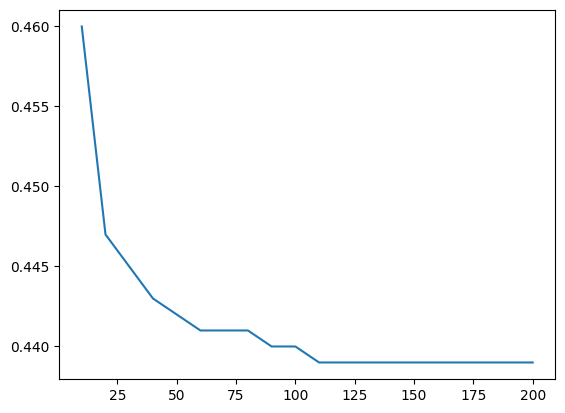

In [17]:

plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [18]:
from tqdm.auto import tqdm

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [02:25<00:00,  7.30s/it]


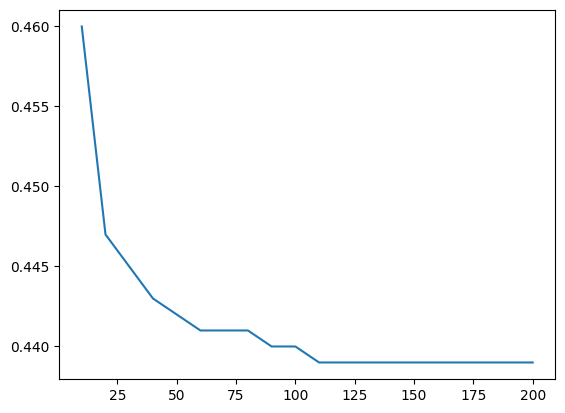

In [20]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [21]:
all_aucs = {}

for depth in [5, 10,15, 20]:
    print('depth: %s' % depth)
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.472
20 -> 0.470
30 -> 0.470
40 -> 0.469
50 -> 0.469
60 -> 0.470
70 -> 0.470
80 -> 0.470
90 -> 0.470


KeyboardInterrupt: 

In [22]:
day="monday"
x=len(day)
print(x)

6


In [23]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20,random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1)

In [24]:
rf.feature_importances_

array([7.65045773e-02, 3.03529486e-02, 1.52629801e-01, 1.53766480e-01,
       5.29427092e-02, 2.56759111e-04, 1.06315060e-03, 3.40855836e-02,
       1.11260623e-03, 9.87885504e-05, 4.31182838e-02, 5.31176713e-02,
       3.91898086e-01, 4.30093850e-03, 4.75161605e-03])

In [25]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,availability_365,0.076505
1,calculated_host_listings_count,0.030353
2,latitude,0.152630
3,longitude,0.153766
4,minimum_nights,0.052943
5,neighbourhood_group=Bronx,0.000257
6,neighbourhood_group=Brooklyn,0.001063
7,neighbourhood_group=Manhattan,0.034086
8,neighbourhood_group=Queens,0.001113
9,neighbourhood_group=Staten Island,0.000099


In [26]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
12,room_type=Entire home/apt,0.391898
3,longitude,0.153766
2,latitude,0.152630
0,availability_365,0.076505
11,reviews_per_month,0.053118


In [27]:
import xgboost as xgb

In [30]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [31]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [32]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [33]:
scores = {}

In [34]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [35]:
scores['eta=0.3'] = parse_xgb_output(output)

In [36]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [37]:
scores['eta=0.1'] = parse_xgb_output(output)

(50.0, 100.0)

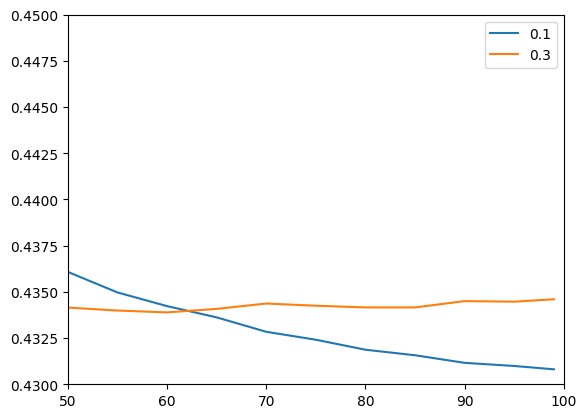

In [38]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

plt.ylim([0.43, 0.45])
plt.xlim([50, 100])